In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import ta as ta

In [45]:
import requests
import pandas as pd

api_key = 'XPQXF0VKO06IFUEJ'
symbol = 'TSLA'
interval = '1min'
outputsize = 'full'

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&outputsize={outputsize}&apikey={api_key}'

response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['Time Series (1min)']).T
df.columns = ['open', 'high', 'low', 'close', 'volume']
df.index = pd.to_datetime(df.index)
historical_data = df.astype(float)

In [57]:
historical_data

,open,high,low,close,volume
0,178.050,178.33,177.12,177.700,3800.0
1,177.780,177.89,177.67,177.700,1073.0
2,177.710,177.85,177.66,177.810,1985.0
3,177.850,178.00,177.80,177.950,1479.0
4,177.980,178.05,177.88,177.960,2298.0
...,...,...,...,...,...
19192,187.400,187.44,187.37,187.395,2152.0
19193,187.395,187.44,187.37,187.410,2553.0
19194,187.410,187.50,187.39,187.490,7039.0
19195,187.490,187.52,187.45,187.450,5954.0


In [58]:
historical_data.to_csv('TSLA_Min.csv', index=False)

In [50]:
historical_data_reversed_rows = historical_data.iloc[::-1].reset_index(drop=True)
historical_data = historical_data_reversed_rows

In [52]:
historical_data
df = historical_data

In [53]:

from sklearn.preprocessing import MinMaxScaler

# Select the features and target
features = df[['open', 'high', 'low', 'close', 'volume']].values
target = df['close'].shift(-30).dropna().values  # Predicting the close price 60 minutes ahead

# Remove the last 60 rows from features as they have no corresponding target
features = features[:-30]

# Split the data into training and testing sets
train_size = int(len(features) * 0)
train_features, test_features = features[:train_size], features[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

# # Scale the features
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_features = scaler.fit_transform(train_features)
# test_features = scaler.transform(test_features)



In [56]:
test_features

array([[ 178.05,  178.33,  177.12,  177.7 , 3800.  ],
       [ 177.78,  177.89,  177.67,  177.7 , 1073.  ],
       [ 177.71,  177.85,  177.66,  177.81, 1985.  ],
       ...,
       [ 187.35,  187.39,  187.28,  187.38, 4913.  ],
       [ 187.38,  187.39,  187.31,  187.31, 5411.  ],
       [ 187.36,  187.36,  187.27,  187.35, 1930.  ]])

In [20]:
def create_sequences(features, target, seq_length):
    sequences = []
    for i in range(len(features) - seq_length):
        seq_features = features[i:i+seq_length]
        seq_target = target[i+seq_length]
        sequences.append((seq_features, seq_target))
    return sequences

seq_length = 30
train_sequences = create_sequences(train_features, train_target, seq_length)
test_sequences = create_sequences(test_features, test_target, seq_length)

train_X, train_y = zip(*train_sequences)
test_X, test_y = zip(*test_sequences)
train_y = np.array(train_y, dtype=np.float32)
test_y = np.array(test_y,dtype=np.float32)


In [33]:
train_y

tensor([187.3400, 187.3200, 187.3200,  ..., 174.5800, 174.6150, 174.5850],
       device='cuda:0')

In [22]:


# Convert to tensors
train_X = torch.tensor(train_X, dtype=torch.float32).to('cuda')
train_y = torch.tensor(train_y, dtype=torch.float32).to('cuda')
test_X = torch.tensor(test_X, dtype=torch.float32).to('cuda')
test_y = torch.tensor(test_y, dtype=torch.float32).to('cuda')

train_data = TensorDataset(train_X, train_y)
test_data = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [23]:
print("train_X shape:", train_X.shape)
print("train_y shape:", train_y.shape)
print("test_X shape:", test_X.shape)
print("test_y shape:", test_y.shape)

train_X shape: torch.Size([15303, 30, 5])
train_y shape: torch.Size([15303])
test_X shape: torch.Size([3804, 30, 5])
test_y shape: torch.Size([3804])


In [24]:
class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to('cuda')
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to('cuda')

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = train_features.shape[1]
hidden_size = 64
num_layers = 2
output_size = 1


In [26]:

model = StockPredictor(input_size, hidden_size, num_layers, output_size).to('cuda')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for features, target in train_loader:
        output = model(features)
        loss = criterion(output, target.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for features, target in test_loader:
            output = model(features)
            loss = criterion(output, target.unsqueeze(1))
            test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Test Loss: {test_loss}')


Epoch 1/100, Loss: 25024.720703125, Test Loss: 25187.502213541666
Epoch 2/100, Loss: 20404.17578125, Test Loss: 20552.59423828125
Epoch 3/100, Loss: 16537.876953125, Test Loss: 16672.967236328124
Epoch 4/100, Loss: 13259.80859375, Test Loss: 13382.316569010416
Epoch 5/100, Loss: 10491.5654296875, Test Loss: 10602.166471354167
Epoch 6/100, Loss: 8173.8134765625, Test Loss: 8273.167203776042
Epoch 7/100, Loss: 6255.00439453125, Test Loss: 6343.764510091146
Epoch 8/100, Loss: 4688.45654296875, Test Loss: 4767.2823486328125
Epoch 9/100, Loss: 3432.004150390625, Test Loss: 3501.5761840820314
Epoch 10/100, Loss: 2444.196533203125, Test Loss: 2505.2114827473956
Epoch 11/100, Loss: 1686.7371826171875, Test Loss: 1739.9208048502603
Epoch 12/100, Loss: 1122.814453125, Test Loss: 1168.922083536784
Epoch 13/100, Loss: 717.1537475585938, Test Loss: 756.9647206624348
Epoch 14/100, Loss: 437.04290771484375, Test Loss: 471.35679219563804
Epoch 15/100, Loss: 252.89804077148438, Test Loss: 282.530113093

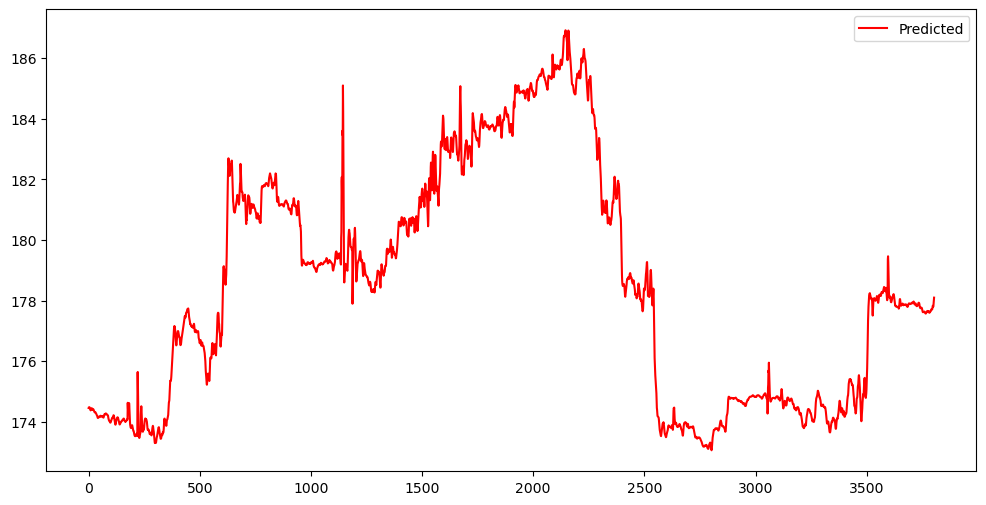

In [28]:

model.eval()
predictions = []
with torch.no_grad():
    for features, _ in test_loader:
        output = model(features)
        predictions.append(output.cpu().numpy())

predictions = np.concatenate(predictions).ravel()

plt.figure(figsize=(12, 6))
# plt.plot(test_target[seq_length:], label='Actual')
plt.plot(predictions, label='Predicted', color='r')
plt.legend()
plt.show()


<Axes: >

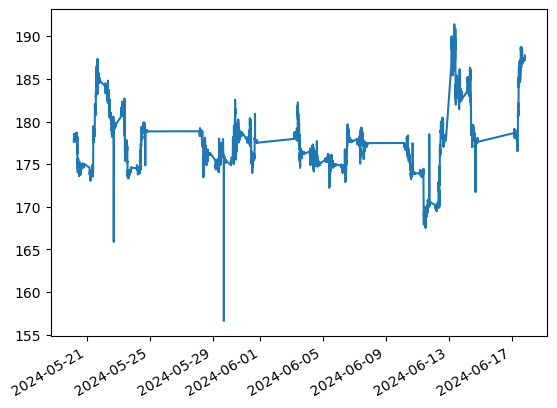

In [30]:
historical_data['close'].plot()

In [31]:
model_path = r"C:\Users\srija\Assignment\AutoTrader\LSTM_TSLA\stock_predictor_lstm_model.pth"
torch.save(model.state_dict(), model_path)
